<img src="https://www.wellcomeconnectingscience.org/wp-content/themes/new_wellcome_connecting_science/dist/assets/svg/logo.svg" alt="WCS Logo" width="150" style="float: left;">
<img src="https://github.com/EveliaCoss/Tutorial_ISCB_LATAM_scATACseq/blob/main/Logo_JAGUAR.png?raw=true" alt="WCS Logo" width="150" style="float: right;">





<h1><center>
  Practical 7: Visualization of protein levels and cell populations
  </center>
  
## About the course 📌

This course is part of the Workshop [Single Cell Genomic Approaches to Study the Immune System - Latin America & the Caribbean](https://coursesandconferences.wellcomeconnectingscience.org/event/single-cell-genomic-approaches-to-study-the-immune-system-latin-america-the-caribbean-20241109/) (9-11 Novembrer 2024), Universidad CES, Medellín, Colombia.

- **Date:** 10 November 2024
- **Course duration**: 1 hour

**Speakers:**
- <font color='orange'>Danilo Ceschin</font> - PI, Centro de Investigación en Medicina Tralaslacional “Severo R. Amuchástegui” (CIMETSA), Instituto Universitario de Ciencias Biomédicas de Córdoba, Argentina.
- <font color='orange'>Felipe Gajardo</font> - PostDoc, Laboratory of Epigenetics, Pontificia Universidad Catolica de Chile.

If you want to come back to the Github, please follow the next link:
*   Github: https://github.com/WCSCourses/Single_Cell_Genomics_ImmuneSys_24


<center>

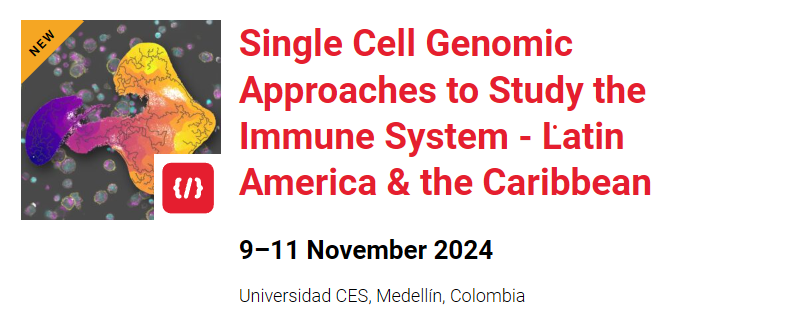

</center>

# 1️⃣ **Setting Up the Environment in Google Colab** 💻

## 1.1. Cleaning the R environment
This step is used to clean up the R environment. By removing all objects with rm(list=ls()), you ensure that no previous variables interfere with your current analysis. Running gc() triggers garbage collection, which helps manage memory usage, especially important when working with large CITE-Seq datasets.

In [ ]:
### clean environment
rm(list=ls())
gc()


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,667024,35.7,1492287,79.7,1312127,70.1
Vcells,1243814,9.5,8388608,64.0,1955578,15.0


## 1.2. Custom Shell Call Function for Google Colab
Google Colab typically runs Python as the default environment. This function lets you run shell commands from within R, ensuring compatibility with Colab’s infrastructure. It captures and prints the output of the shell commands. This functionality is useful when managing system configurations or installing packages in Colab while using the R kernel.



In [ ]:
## https://stackoverflow.com/questions/70025153/how-to-access-the-shell-in-google-colab-when-running-the-r-kernel
shell_call <- function(command, ...) {
  result <- system(command, intern = TRUE, ...)
  cat(paste0(result, collapse = "\n"))
}

## 1.3. Downloads and sets up the R2U
In this section, the script downloads and sets up the R2U repository for package management. R2U is a fast way to install R packages on Ubuntu (the operating system underlying Google Colab). This makes package installation quicker and more efficient. The script sets the appropriate permissions for the downloaded shell script, runs it, and then enables the bspm package for managing packages. After installation, the script is removed.

This is an important step to streamline package installations, reducing the time needed for installing necessary libraries for CITE-Seq data analysis, and ensuring that your environment is properly configured for your workflow.

In [ ]:
## Setup R2U
download.file("https://github.com/eddelbuettel/r2u/raw/master/inst/scripts/add_cranapt_jammy.sh",
              "add_cranapt_jammy.sh")
Sys.chmod("add_cranapt_jammy.sh", "0755")
shell_call("./add_cranapt_jammy.sh")
bspm::enable()
options(bspm.version.check=FALSE)
shell_call("rm add_cranapt_jammy.sh")


52 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists...
Building dependency tree...
Reading state information...
ca-certificates is already the newest version (20240203~22.04.1).
gnupg is already the newest version (2.2.27-3ubuntu2.1).
wget is already the newest version (1.21.2-2ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 52 not upgraded.
-----BEGIN PGP PUBLIC KEY BLOCK-----

mQINBFM+sY8BEADA70T+U0/2WNjOTLvytuXLvBC4vgA8hYvOaBS1cL3d8lu4mwr4
W84/6p4v/mXle/0eIO2D2g+XfK72ZHZxpS+bb7yPxrkCDLGxwUd/khtTJHSbbKFo
J73AsABflMe+8qv+E74+QTiXErTCNioFRz18sa0EvOnEAiokau6TZVYY2z9YjBNI
yEjTi+z+g8c1RL6VmrFEpTicTpafOLbkRyw0VKnAKG7Ytp3Ksc1G9/IAoKw3Q9La
0DJb5iX6hyB7+PNid6htK4LtPKZ2dNSrnRvNNkjj5BgcM2AT1hmxbzHNzIVmPoKA
CQFrkdjog3/PcyjdtZG7cfoSDXrbIAZeAa2ngLv9C/DJatVDd6maPOe66gLo7+As
ErMvO9vtiouqLdurW+Lhx0jFW9Ca3g1taLfbSDyS3X1mOGWcisbQvBqkIuoDQTeS
V4Z04wrwTZ1HtweKG/s5fmPtZNGWVI5YNRLIwdmbGzFTMPu2XTAOd+xSK2H+46Kh
Sh4kFeP6pBh5No4ET1MzIuDAHwl0J+mbWKPH4tIosYkcVmv

Tracing function "install.packages" in package "utils"



## 1.4. Install and Load Required Packages
This function is essential for setting up your CITE-Seq analysis environment in R. It ensures that all required packages are installed and loaded, which is crucial when working with multiple packages for data visualization, statistical analysis, or single-cell analysis in CITE-Seq.

For this tutorial, we will need the followings packages:

+ `Seurat`, the swiss-knife toolkit for analysing single-cell data in R.
+ `ggplot2`, is a system for declaratively creating graphics, based on The Grammar of Graphics.
+ `patchwork`, is a package designed to make plot composition in R extremely simple and powerful.

In [ ]:
loadAndInstallPackages <- function(pkgs) {
  # Function to load packages with suppressed warnings and messages
  myrequire <- function(pkg) {
    suppressWarnings(suppressMessages(suppressPackageStartupMessages(require(pkg, character.only = TRUE))))
  }

  # Check which packages are not installed
  new.pkgs <- pkgs[!(pkgs %in% installed.packages()[, "Package"])]

  # Install missing packages
  if (length(new.pkgs) > 0) {
    message("Installing the following packages: ", paste(new.pkgs, collapse = ", "))
    if (!requireNamespace("BiocManager", quietly = TRUE))
      install.packages("BiocManager")
    BiocManager::install(new.pkgs, dependencies = TRUE)
  }

  # Load all packages, including newly installed ones
  ok <- sapply(pkgs, myrequire)

  # Report if any package could not be loaded
  if (!all(ok)) {
    message("The following packages could not be loaded: ", paste(pkgs[!ok], collapse = ", "))
  } else {
    message("All packages were successfully loaded.")
  }
}

packages <- c("Seurat", "ggplot2", "patchwork")

# installation and/or calling packages
loadAndInstallPackages(packages)

All packages were successfully loaded.



# 2️⃣ **Download and Uncompress CITE-Seq Count**

The count matrices contain the core data for single-cell multimodal analysis, including RNA and protein expression levels. Accessing this data is the foundational step for conducting subsequent analyses, such as exploring gene expression patterns or protein marker abundance across different cell types.

In [ ]:
# Download and uncompress count matrices
system("wget https://github.com/WCSCourses/Single_Cell_Genomics_ImmuneSys_24/raw/refs/heads/main/course_data/Module2_CITEseq/10X_multimodal_dataset_downsample3000.tar.gz")
system("tar xf 10X_multimodal_dataset_downsample3000.tar.gz")

# 3️⃣ **Load Gene Expression and Antibody-Derived Tag (ADT) Data**

Load Data from the multimodal single-cell analysis. It allows us to work with two different types of molecular data—gene expression and protein expression—simultaneously. The combination of these datasets helps in gaining a more comprehensive understanding of cellular states, as the protein data often complements the RNA expression profile, especially in identifying cell types and subtypes.


In [ ]:
gex_data <- Read10X(data.dir = './YASCP_downsample_3000_MEX_GEX/',
                    unique.features = T,
                    strip.suffix = T)

adt_data <- Read10X(data.dir = './YASCP_downsample_3000_MEX_ADT/',
                    unique.features = T,
                    strip.suffix = T)

In [ ]:
# Note that since measurements were made in the same cells, the two matrices have identical
# column names
#checks if the cell barcodes in gex_data and adt_data match, ensuring both datasets are aligned for the same cells in multimodal analysis.
all.equal(colnames(gex_data), colnames(adt_data))

[1] TRUE

# 4️⃣ **Create Seurat object**

This creates a Seurat object using the gene expression data (`gex_data`). The `Assays(yascp)` command shows that the default assay stores RNA measurements.

In [ ]:
# creates a Seurat object based on the scRNA-seq data
yascp <- CreateSeuratObject(counts = gex_data)

# By default, the yascp object contains an assay storing RNA measurement
Assays(yascp)

[1] "RNA"

# 5️⃣ **Integrating RNA and ADT Data into Seurat Object**

Integrating both RNA and ADT (Antibody-Derived Tag) data in a Seurat object. After creating a new assay for ADT, it is added to the Seurat object, allowing us to handle multimodal data for further analysis, such as exploring both gene expression and protein abundance in a unified framework.

In [ ]:
# create a new assay to store ADT information
adt_assay <- CreateAssay5Object(counts = adt_data)

# add this assay to the previously created Seurat object
yascp[["ADT"]] <- adt_assay

# Validate that the object now contains multiple assays
Assays(yascp)

[1] "RNA" "ADT"

# 6️⃣ **Data Normalization and Dimensionality Reduction**

This section applies a series of preprocessing steps on the Seurat object to prepare the single-cell RNA-seq data for analysis. The steps include normalizing the data, identifying variable features, scaling the data, performing Principal Component Analysis (PCA) for dimensionality reduction, and clustering the cells. Finally, UMAP is used for visualizing the clusters in two dimensions, which helps in understanding the cellular heterogeneity within the dataset. The DimPlot function displays the UMAP visualization with cluster labels.

Cluster cells on the basis of their scRNA-seq profiles The steps below represent a quick clustering of the PBMCs based on the scRNA-seq data.

In [ ]:
# Note that all operations below are performed on the RNA assay Set and verify that the
# default assay is RNA
DefaultAssay(yascp) <- "RNA"
DefaultAssay(yascp)

[1] "RNA"

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix



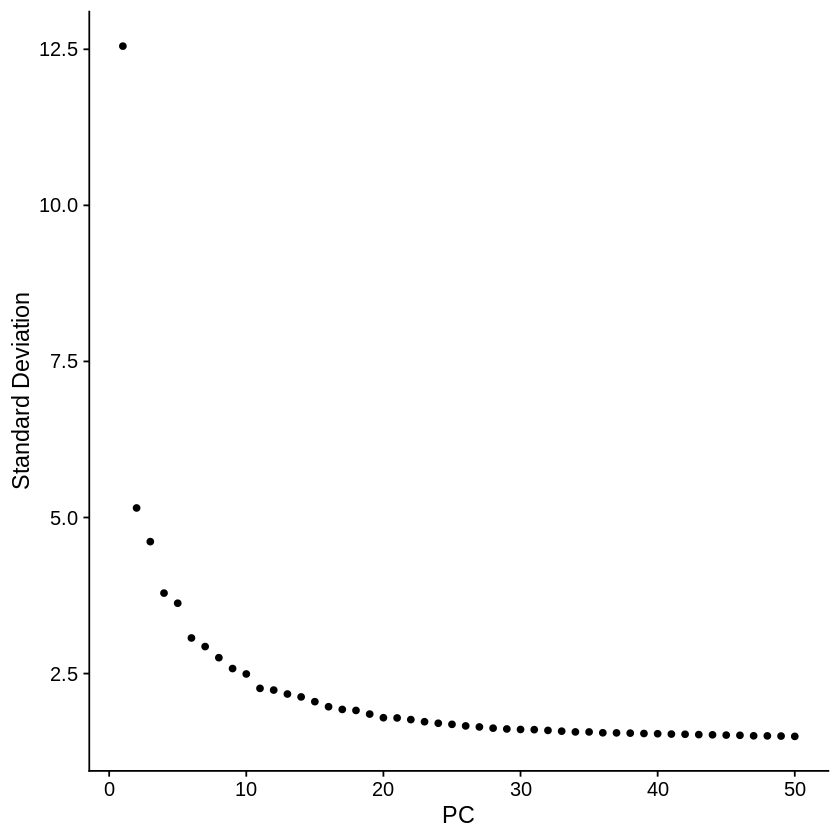

In [ ]:
# perform visualization and clustering steps
yascp <- NormalizeData(yascp)
yascp <- FindVariableFeatures(yascp)
yascp <- ScaleData(yascp)
yascp <- RunPCA(yascp, verbose = FALSE)

# perform ElbowPlot to select dimensions for clustering process
ElbowPlot(yascp, ndims = 50)

Computing nearest neighbor graph

Computing SNN

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
06:46:35 UMAP embedding parameters a = 0.9922 b = 1.112

06:46:35 Read 3000 rows and found 20 numeric columns

06:46:35 Using Annoy for neighbor search, n_neighbors = 30

06:46:35 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

06:46:35 Writing NN index file to temp file /tmp/RtmpmgndNO/fileb4711c5db4b2

06:46:35 Searching Annoy index using 1 thread, search_k = 3000

06:46:36 Annoy recall = 100%

06:46:37 Commencing smooth kNN distance cali

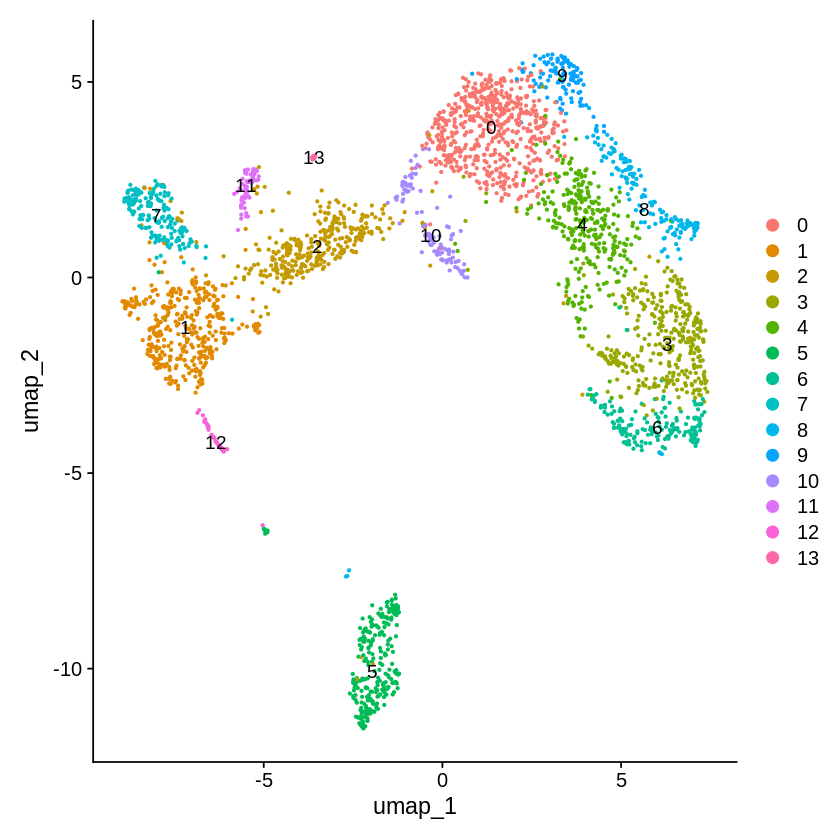

In [ ]:
# clustering and visualization
yascp <- FindNeighbors(yascp, dims = 1:20)
yascp <- FindClusters(yascp, resolution = 0.8, verbose = FALSE)
yascp <- RunUMAP(yascp, dims = 1:20)
DimPlot(yascp, label = TRUE)

#7\. Normalizing Data for Different Assays
In this section, we set the default assay to "ADT" to normalize the antibody-derived tag (ADT) data using the centered log-ratio (CLR) method. After normalization, we switch the default assay back to "RNA" for further analysis of the RNA data. This process ensures that each assay is properly prepared for downstream analysis while maintaining the flexibility to switch between modalities as needed.

In [ ]:
# set the default assay to "ADT" to normalize the antibody-derived tag (ADT) data using the centered log-ratio (CLR) method.
DefaultAssay(yascp) <- "ADT"
yascp <- NormalizeData(yascp, normalization.method = "CLR", margin = 2)

# After normalization, we switch the default assay back to "RNA" for further analysis of the RNA data.
DefaultAssay(yascp) <- "RNA"

# This process ensures that each assay is properly prepared for downstream analysis
# while maintaining the flexibility to switch between modalities as needed.

# Note that the following command is an alternative but returns the same result
yascp <- NormalizeData(yascp, normalization.method = "CLR", margin = 2, assay = "ADT")

Normalizing layer: counts

Normalizing across cells

Normalizing layer: counts

Normalizing across cells



#8\. Visualize multiple modalities side-by-side
We have generated clusters from the scRNA-seq profiles, allowing us to visualize the expression of either protein or RNA molecules within our dataset. Notably, Seurat offers various methods to switch between modalities and to specify which one you wish to analyze or visualize. This capability is crucial because the same feature may be measured in multiple modalities; for instance, this dataset includes separate measurements for the B cell marker CD19 at both protein and RNA levels.

### 8.1.1 Visualizing CD19 Protein and RNA Expression

We visualize the expression of the CD19 marker in both protein and RNA modalities. By first setting the default assay to "ADT," we create a feature plot for CD19 protein expression. Then, we switch to the "RNA" assay to generate a feature plot for CD19 RNA expression. The resulting plots are displayed side-by-side, allowing for a direct comparison of protein and RNA levels for the same marker within the dataset.

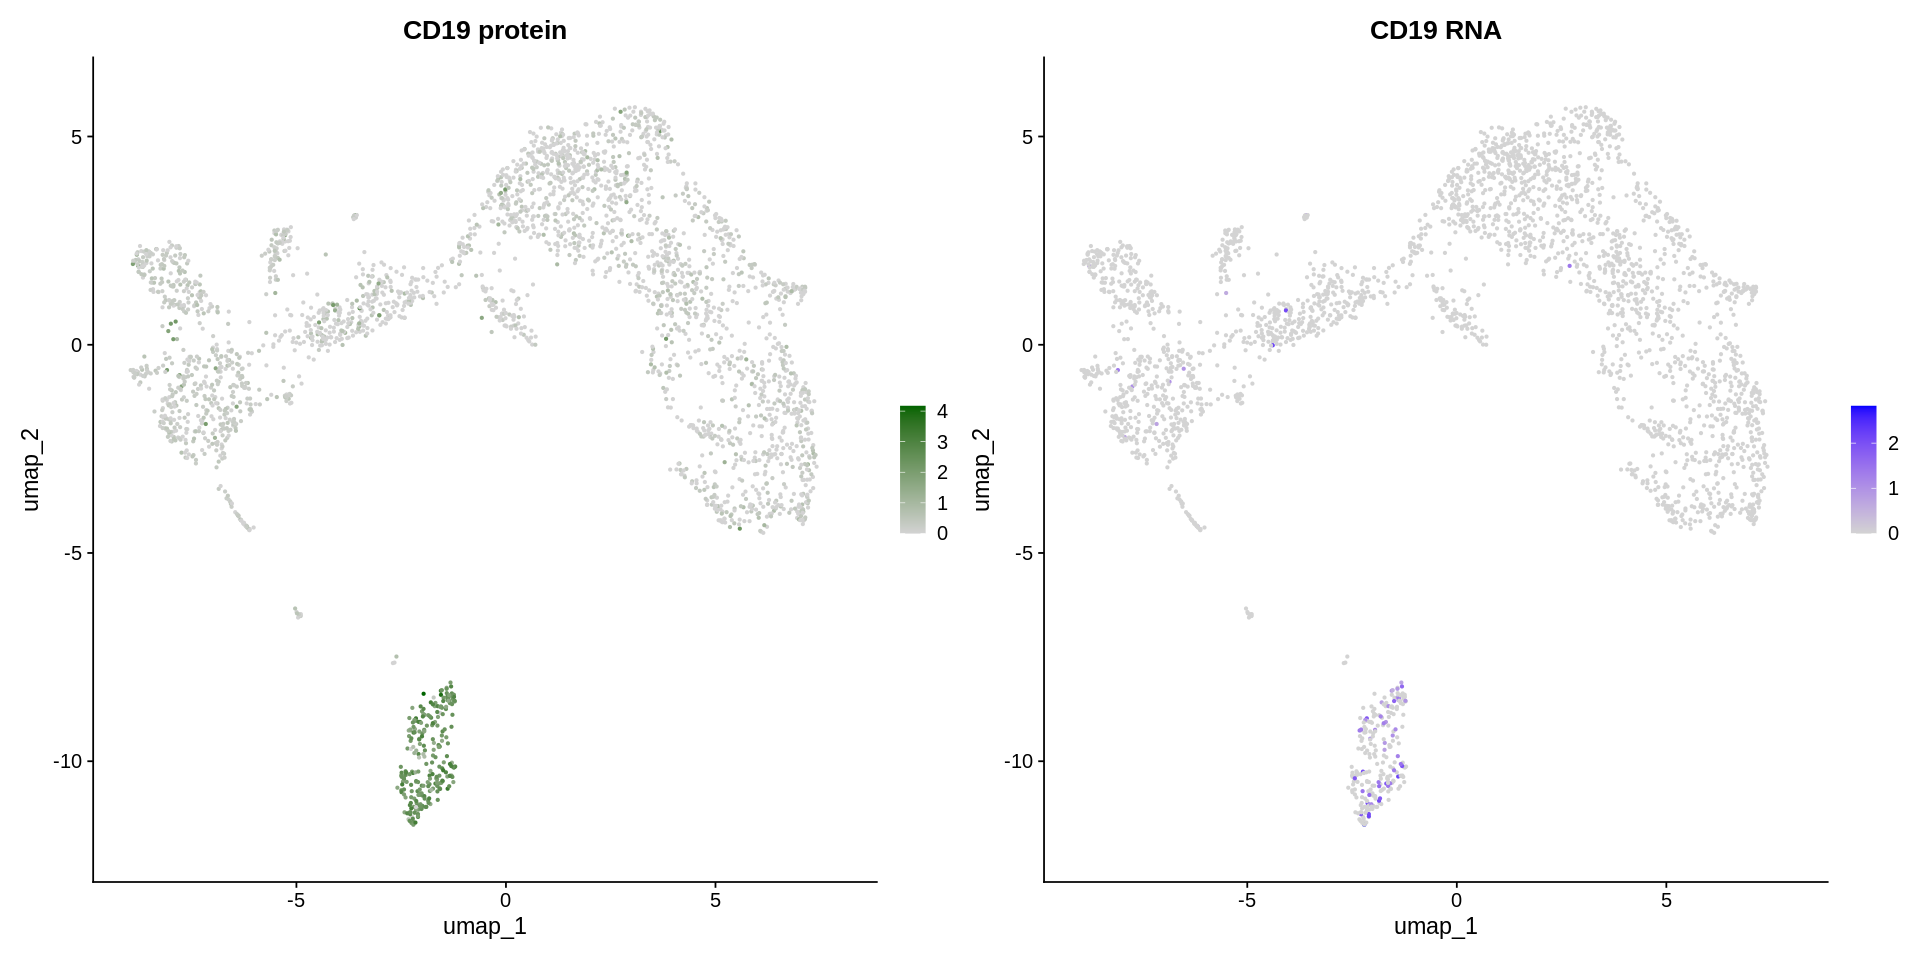

In [ ]:
# Set plot size
options(repr.plot.width = 16, repr.plot.height = 8)

# Now, we will visualize CD19 levels for RNA and protein By setting the default assay, we can
# visualize one or the other
DefaultAssay(yascp) <- "ADT"
p1 <- FeaturePlot(yascp, "CD19", cols = c("lightgrey", "darkgreen")) + ggtitle("CD19 protein")
DefaultAssay(yascp) <- "RNA"
p2 <- FeaturePlot(yascp, "CD19") + ggtitle("CD19 RNA")

# place plots side-by-side
p1 | p2

### 8.1.2 Visualizing CD14 Protein and RNA Expression

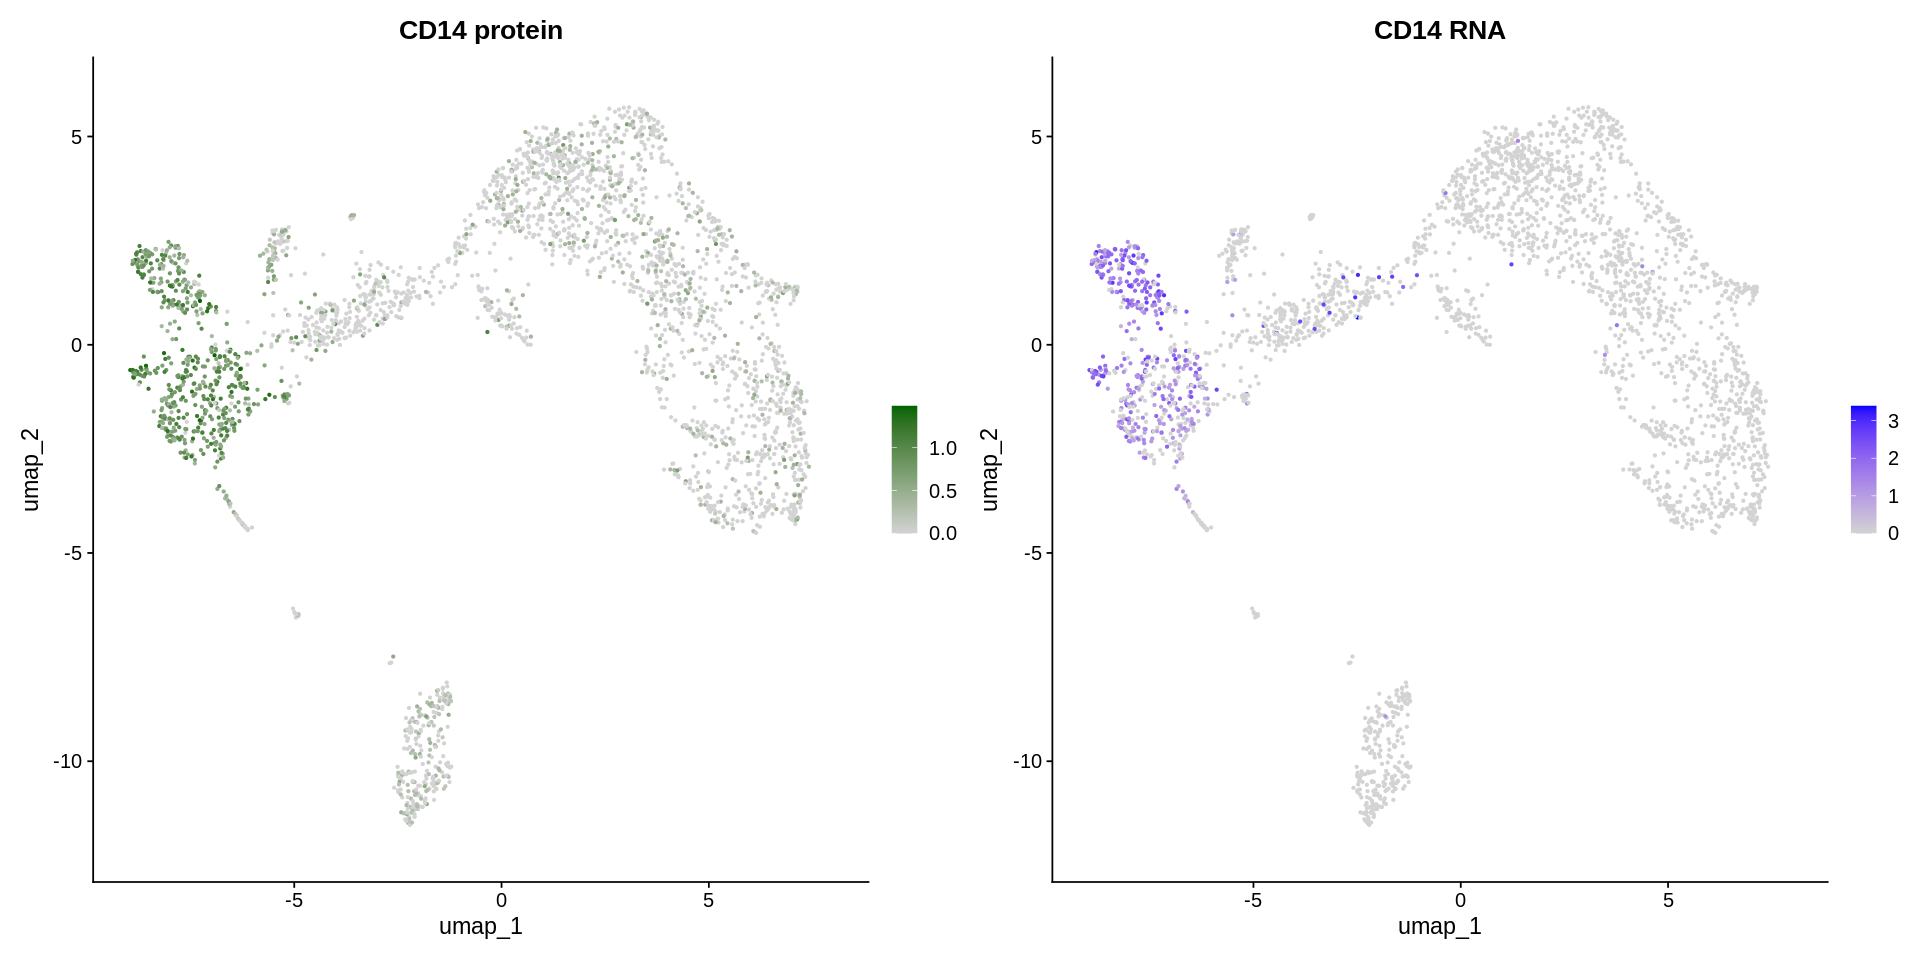

In [ ]:
# Now, we will visualize CD14 levels for RNA and protein By setting the default assay, we can
# visualize one or the other
DefaultAssay(yascp) <- "ADT"
p3 <- FeaturePlot(yascp, "CD14", cols = c("lightgrey", "darkgreen")) + ggtitle("CD14 protein")
DefaultAssay(yascp) <- "RNA"
p4 <- FeaturePlot(yascp, "CD14") + ggtitle("CD14 RNA")

# place plots side-by-side
p3 | p4

In [ ]:
# Alternately, we can use specific assay keys to specify a specific modality Identify the key
# for the RNA and protein assays
Key(yascp[["RNA"]])

[1] "rna_"

In [ ]:
Key(yascp[["ADT"]])

[1] "adt_"

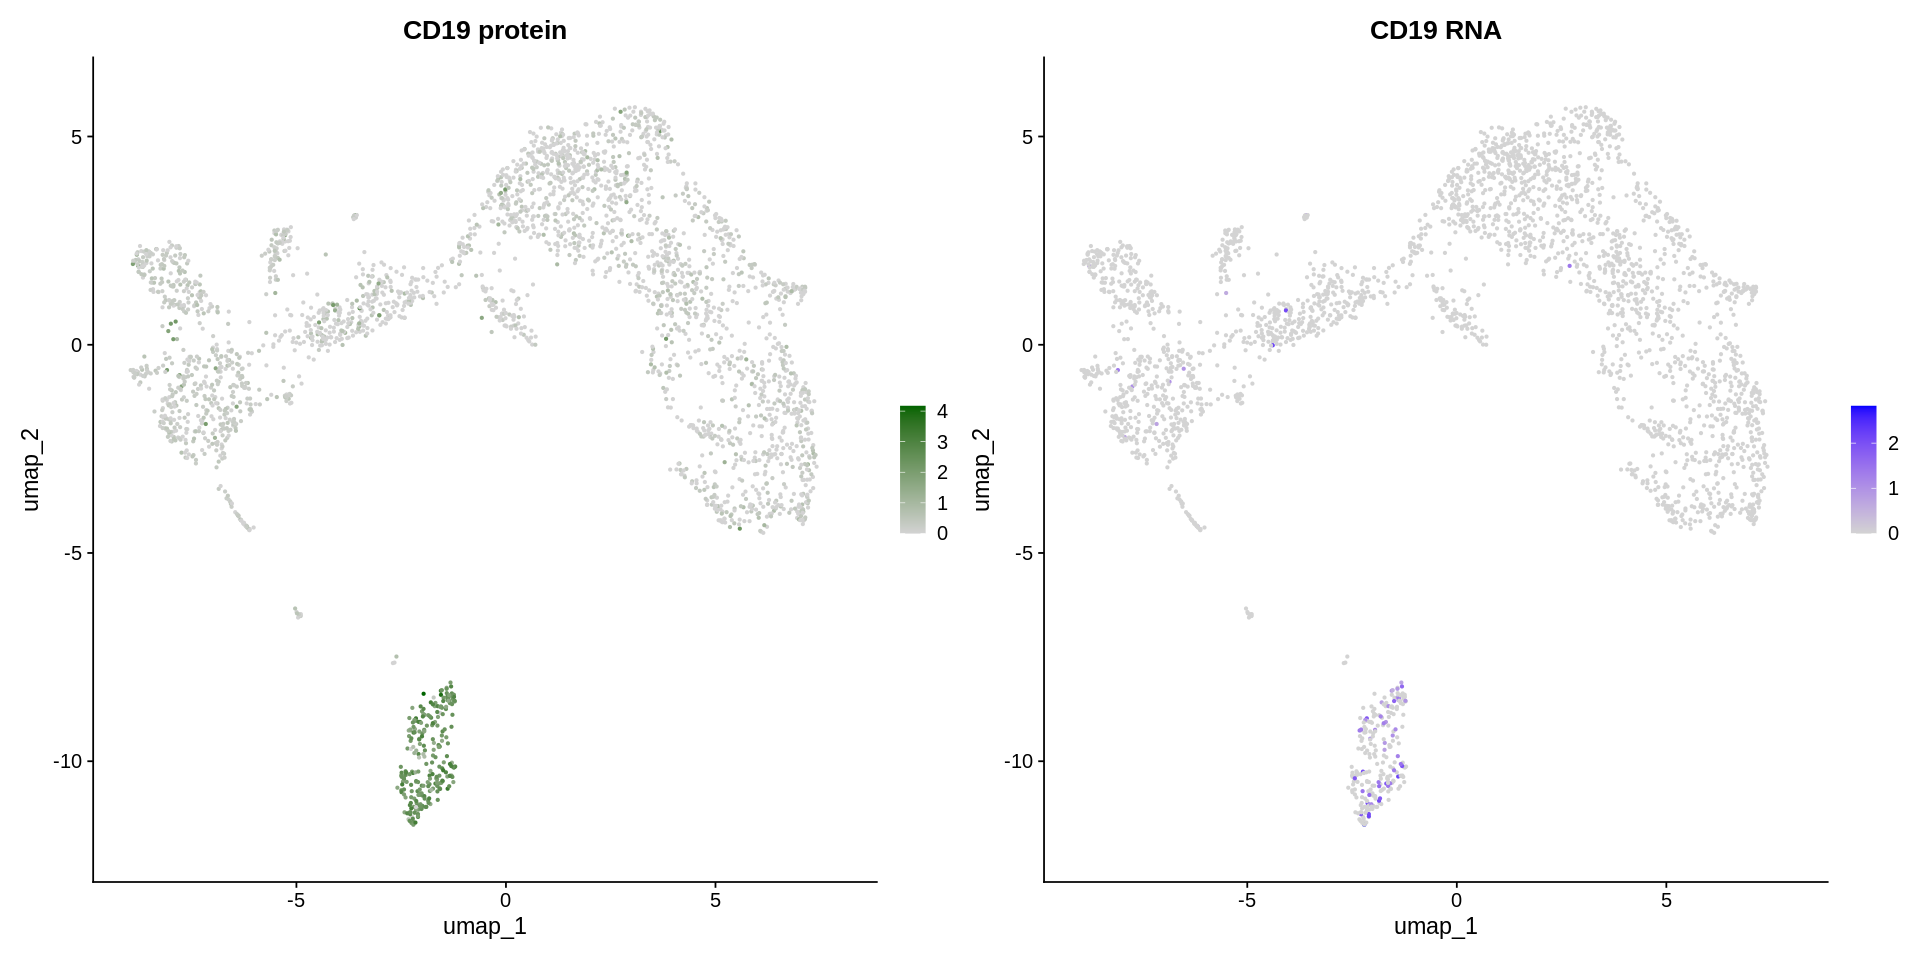

In [ ]:
# Now, we can include the key in the feature name, which overrides the default assay
p1 <- FeaturePlot(yascp, "adt_CD19", cols = c("lightgrey", "darkgreen")) + ggtitle("CD19 protein")
p2 <- FeaturePlot(yascp, "rna_CD19") + ggtitle("CD19 RNA")
p1 | p2

## 8.2 Identify cell surface markers for scRNA-seq clusters
We can leverage our paired CITE-seq measurements to help annotate clusters derived from scRNA-seq, and to identify both protein and RNA markers.

### 8.2.1 Visualizing Protein Marker Expression with Violin Plots

Here, we use violin plots to visualize the distribution of protein expression levels for specific markers across the different cell clusters. These plots provide insights into the variability of protein levels within and between clusters, offering a clearer picture of marker expression patterns in the dataset.

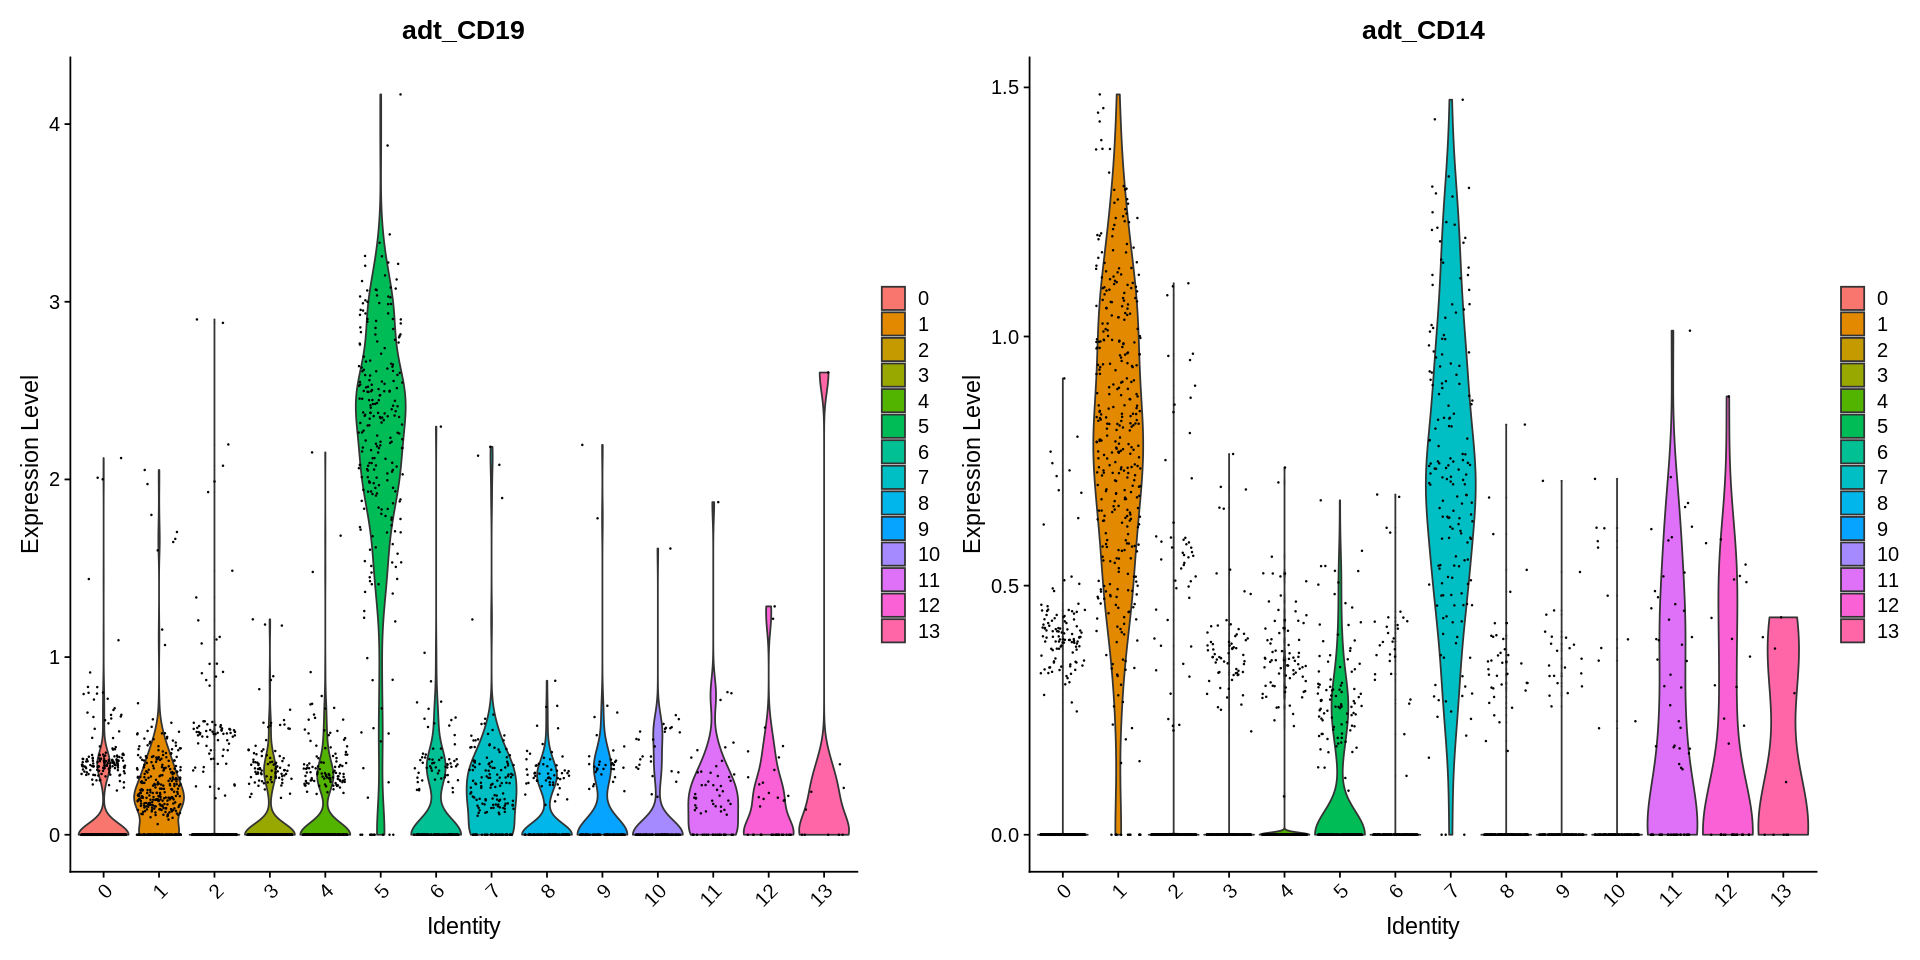

In [ ]:
# As we know, for instance, that CD19 is a B cell marker and CD14 is a monocyte marker,
# we can identify different clusters expressing these proteins on the surface.
p1 <- VlnPlot(yascp, "adt_CD19")
p2 <- VlnPlot(yascp, "adt_CD14")
p1 | p2


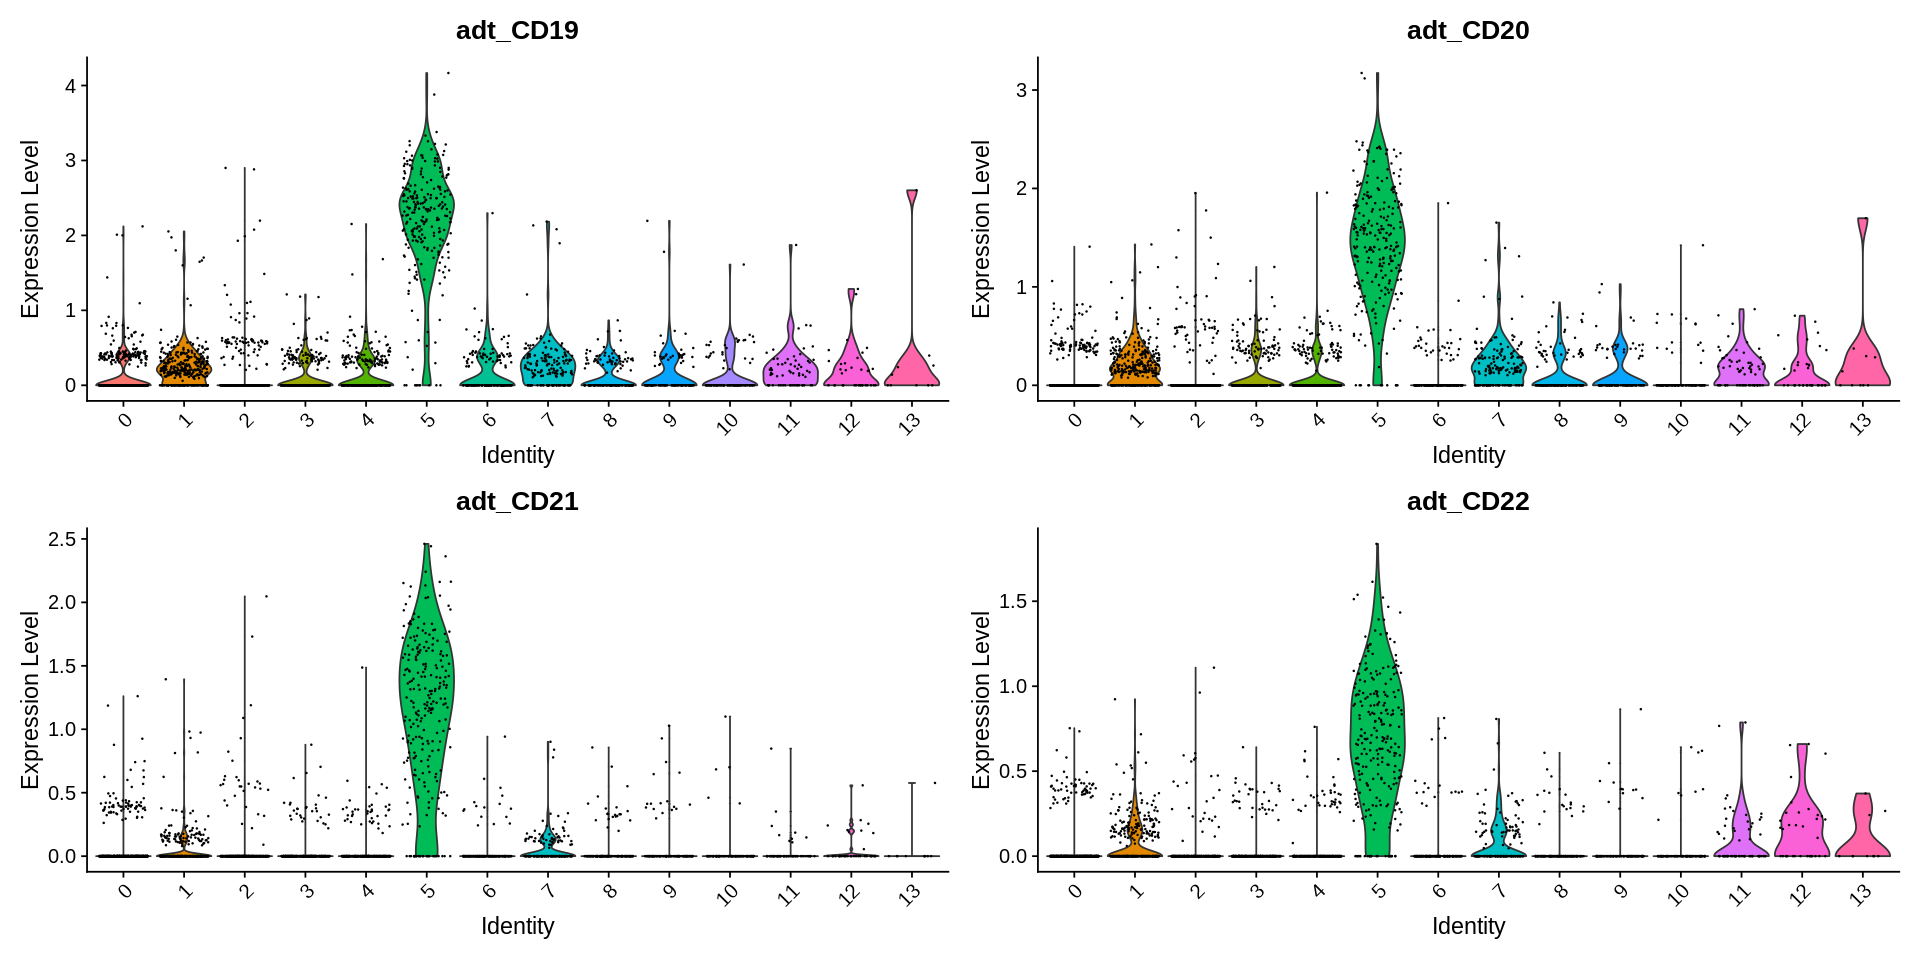

In [ ]:
## other way
features=c("adt_CD19", "adt_CD20", "adt_CD21", "adt_CD22")
VlnPlot(yascp, features = features, ncol = 2)

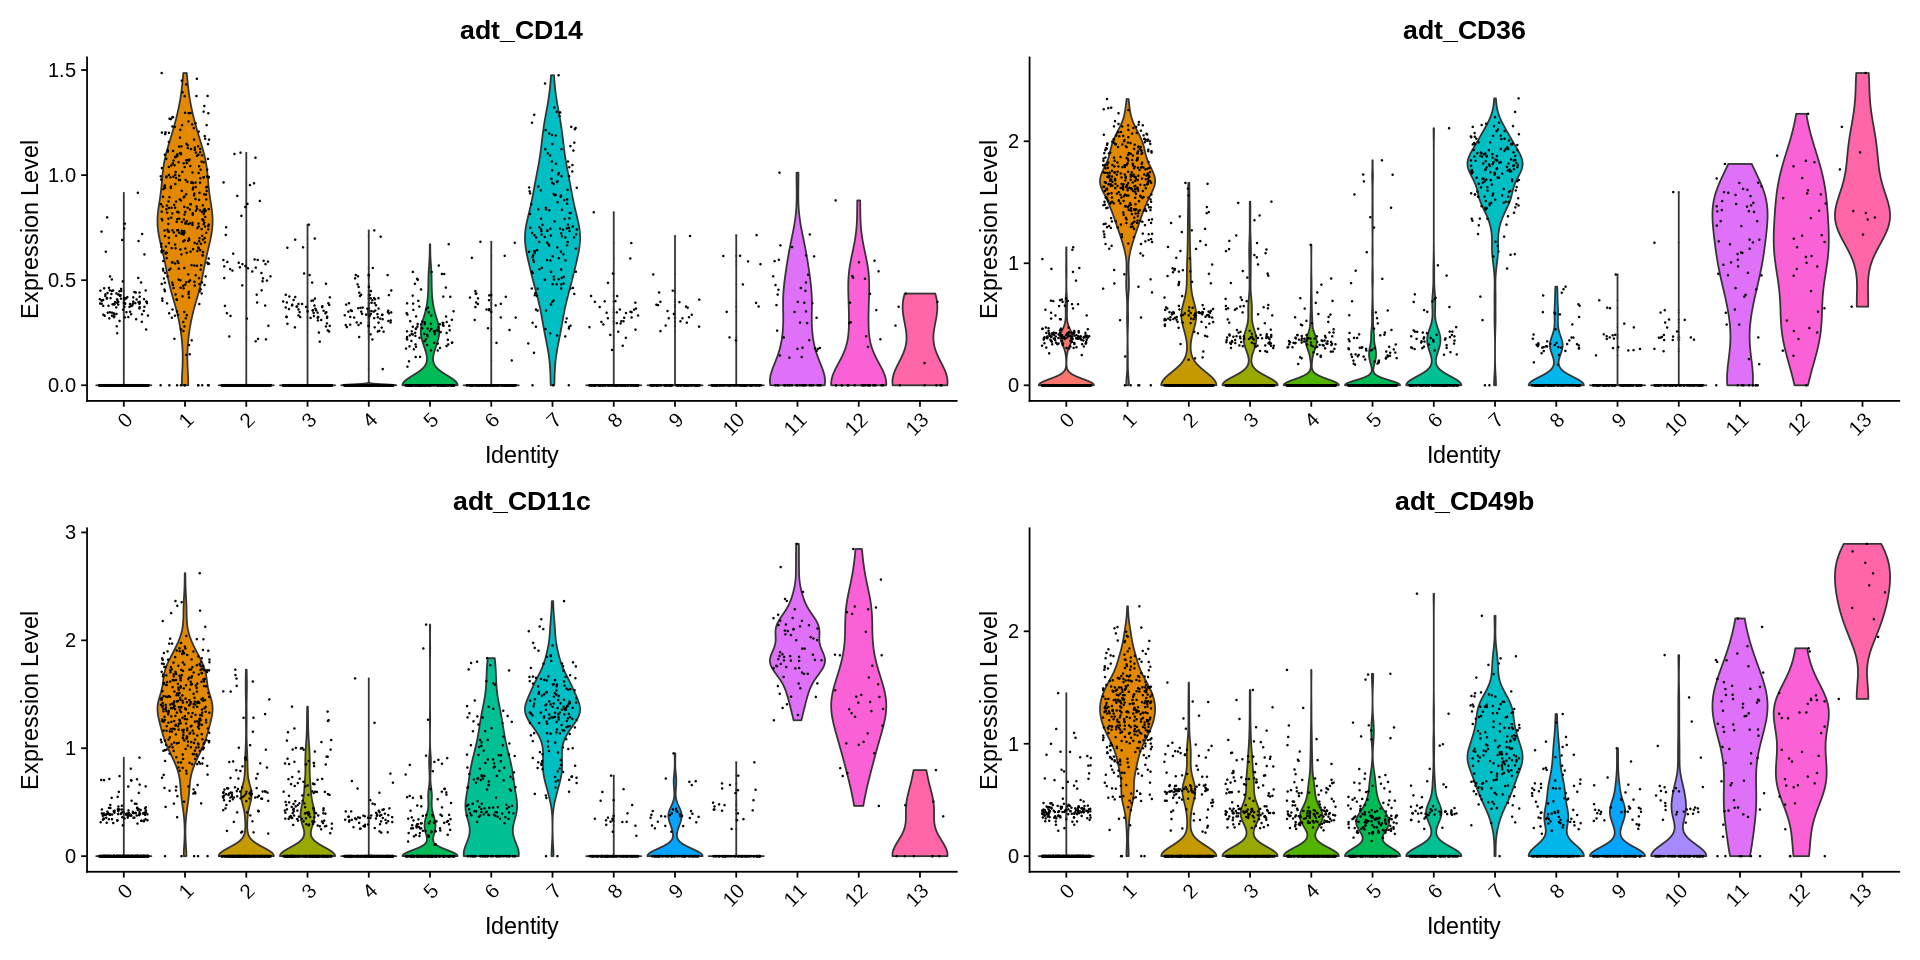

In [ ]:
## other way
features=c("adt_CD14", "adt_CD36", "adt_CD11c", "adt_CD49b")
VlnPlot(yascp, features = features, ncol = 2)

## 8.3 Installing and Loading Presto for Differential Expression Analysis

We install and load the **Presto** package, which is a fast tool for performing differential expression analysis in single-cell RNA-seq data. Presto is designed to quickly compute markers across large datasets, enabling efficient identification of differentially expressed genes across clusters or conditions.

In [ ]:
#install.packages('devtools')
devtools::install_github('immunogenomics/presto')
library(presto)

Skipping install of 'presto' from a github remote, the SHA1 (7636b3d0) has not changed since last install.
  Use `force = TRUE` to force installation

Loading required package: Rcpp

Loading required package: data.table



### 8.3.1 Identifying Marker Genes for Clusters

Here, we identify **marker genes** for specific clusters in both the ADT (protein) and RNA assays. The `FindMarkers` function is used to find genes that are differentially expressed in a particular cluster (in this case, cluster 6) compared to other clusters, helping us understand the unique characteristics of each cell group.

In [ ]:
# we can also identify alternative protein and RNA markers for this cluster through
# differential expression
adt_markers_cl6 <- FindMarkers(yascp, ident.1 = 6, assay = "ADT")
rna_markers_cl6 <- FindMarkers(yascp, ident.1 = 6, assay = "RNA")

In [ ]:
head(adt_markers_cl6, 10)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CD16,4.260105e-77,2.157599,0.942,0.561,5.836344e-75
CD56,4.181949e-76,2.251572,0.930,0.451,5.729271e-74
CD94,8.945468e-75,2.315441,0.930,0.465,1.225529e-72
CD122-(IL-2R-),6.224553e-72,1.919883,0.930,0.548,8.527637e-70
GPR56,1.485155e-70,2.132676,0.901,0.406,2.034663e-68
CD335-(NKp46),9.417061e-63,2.046788,0.877,0.480,1.290137e-60
CD244-(2B4),2.391733e-56,1.231886,0.977,0.686,3.276674e-54
CD7,8.764108e-39,1.211280,0.918,0.522,1.200683e-36
CD161,9.927471e-38,1.190982,0.895,0.644,1.360064e-35


In [ ]:
head(rna_markers_cl6, 10)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SPON2,3.851267e-173,4.410999,0.696,0.060,8.362257e-169
GZMB,5.894032e-151,3.379997,0.865,0.125,1.279771e-146
GNLY,3.129604e-140,3.364458,0.977,0.220,6.795308e-136
NKG7,1.906987e-127,3.022885,1.000,0.279,4.140640e-123
FGFBP2,1.420760e-123,3.284552,0.743,0.107,3.084896e-119
KLRB1,3.521246e-118,2.848404,0.830,0.148,7.645681e-114
KLRD1,2.546769e-116,3.172595,0.731,0.113,5.529799e-112
KLRF1,6.016216e-114,3.224025,0.532,0.052,1.306301e-109
CST7,4.527800e-112,2.613122,0.936,0.209,9.831213e-108


In [ ]:
# we can also identify alternative protein and RNA markers for this cluster through
# differential expression
adt_markers_cl1 <- FindMarkers(yascp, ident.1 = 1, assay = "ADT")
rna_markers_cl1 <- FindMarkers(yascp, ident.1 = 1, assay = "RNA")
head(adt_markers_cl1, 10)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CD33,4.502273e-259,2.896789,0.981,0.186,6.168113e-257
CD64,2.652345e-232,2.813033,0.946,0.186,3.633713e-230
CD14,7.515142e-218,2.588578,0.970,0.278,1.029574e-215
CD36,2.034036e-206,2.547962,0.986,0.342,2.786629e-204
CD155-(PVR),1.850597e-195,2.127414,0.989,0.424,2.535317e-193
CD49b,1.651773e-189,2.202898,0.989,0.419,2.262929e-187
CD328-(Siglec-7),2.794314e-184,2.242730,0.951,0.241,3.828210e-182
CD11c,1.071773e-181,2.202118,0.986,0.355,1.468328e-179
CD62P-(P-Selectin),5.781686e-175,2.132020,0.986,0.479,7.920910e-173


In [ ]:
head(rna_markers_cl1, 10)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CSTA,2.937280e-271,3.093716,0.883,0.101,6.377716e-267
TNFAIP2,1.267131e-256,2.902986,0.916,0.120,2.751322e-252
S100A8,1.214458e-246,2.633249,0.962,0.158,2.636952e-242
FCN1,4.277891e-241,2.627993,0.967,0.155,9.288585e-237
IFI30,5.385740e-236,2.698564,0.981,0.185,1.169406e-231
SPI1,2.037481e-234,2.766705,0.954,0.169,4.423983e-230
CSF3R,1.449056e-229,3.060159,0.774,0.092,3.146336e-225
S100A9,2.620388e-228,2.809104,0.984,0.207,5.689649e-224
S100A12,1.117402e-227,2.882227,0.807,0.097,2.426216e-223


### 8.3.2 Scatter Plot of Protein Expression

This scatter plot visualizes the relationship between the expression levels of proteins across all cells. It helps to explore potential co-expression patterns or identify populations where these markers are mutually exclusive, which can provide insights into cell type identification. Pearson correlation between the two features is displayed above the plot.


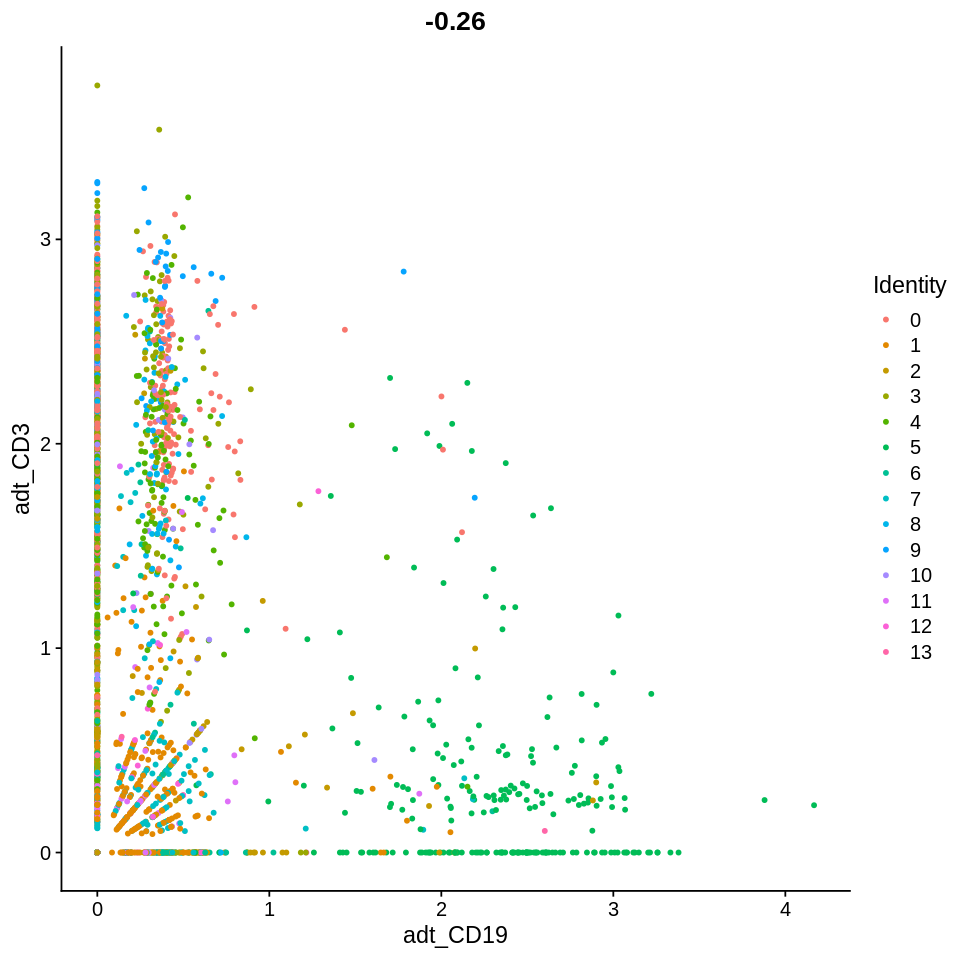

In [ ]:
# Set plot size
options(repr.plot.width = 8, repr.plot.height = 8)

# view relationship between two proteins
FeatureScatter(yascp, feature1 = "adt_CD19", feature2 = "adt_CD3")

In [ ]:
rownames(yascp@assays$ADT)

[1] "CD86"                              "CD274-(B7-H1-PD-L1)"              
  [3] "CD270-(HVEM-TR2)"                  "CD155-(PVR)"                      
  [5] "CD112-(Nectin-2)"                  "CD47"                             
  [7] "CD48"                              "CD40"                             
  [9] "CD154"                             "CD52"                             
 [11] "CD3"                               "CD8"                              
 [13] "CD56"                              "CD19"                             
 [15] "CD33"                              "CD11c"                            
 [17] "HLA-A-B-C"                         "CD45RA"                           
 [19] "CD123"                             "CD7"                              
 [21] "CD105"                             "CD49f"                            
 [23] "CD194-(CCR4)"                      "CD4"                              
 [25] "CD44"                              "CD14"                             
 [27] "CD16"                              "CD25"                             
 [29] "CD45RO"                            "CD279"                            
 [31] "TIGIT-(VSTM3)"                     "Mouse-IgG1-isotype-Ctrl"          
 [33] "Mouse-IgG2a-isotype-Ctrl"          "Mouse-IgG2b-isotype-Ctrl"         
 [35] "Rat-IgG2b-Isotype-Ctrl"            "CD20"                             
 [37] "CD335-(NKp46)"                     "CD31"                             
 [39] "CD146"                             "IgM"                              
 [41] "CD5"                               "CD183-(CXCR3)"                    
 [43] "CD195-(CCR5)"                      "CD32"                             
 [45] "CD196-(CCR6)"                      "CD185-(CXCR5)"                    
 [47] "CD103-(Integrin-E)"                "CD69"                             
 [49] "CD62L"                             "CD161"                            
 [51] "CD152-(CTLA-4)"                    "CD223-(LAG-3)"                    
 [53] "KLRG1-(MAFA)"                      "CD27"                             
 [55] "CD107a-(LAMP-1)"                   "CD95-(Fas)"                       
 [57] "CD134-(OX40)"                      "HLA-DR"                           
 [59] "CD1c"                              "CD11b"                            
 [61] "CD64"                              "CD141-(Thrombomodulin)"           
 [63] "CD1d"                              "CD314-(NKG2D)"                    
 [65] "CD35"                              "CD57-Recombinant"                 
 [67] "CD272-(BTLA)"                      "CD278-(ICOS)"                     
 [69] "CD58-(LFA-3)"                      "CD39"                             
 [71] "CX3CR1"                            "CD24"                             
 [73] "CD21"                              "CD11a"                            
 [75] "CD79b-(Ig-)"                       "CD244-(2B4)"                      
 [77] "CD169-(Sialoadhesin-Siglec-1)"     "integrin-7"                       
 [79] "CD268-(BAFF-R)"                    "CD42b"                            
 [81] "CD54"                              "CD62P-(P-Selectin)"               
 [83] "CD119-(IFN--R-chain)"              "TCR-"                             
 [85] "Rat-IgG1-isotype-Ctrl"             "Rat-IgG2a-Isotype-Ctrl"           
 [87] "Armenian-Hamster-IgG-Isotype-Ctrl" "CD122-(IL-2R-)"                   
 [89] "CD267-(TACI)"                      "Fc-RI-"                           
 [91] "CD41"                              "CD137-(4-1BB)"                    
 [93] "CD163"                             "CD83"                             
 [95] "CD124-(IL-4R-)"                    "CD13"                             
 [97] "CD2"                               "CD226-(DNAM-1)"                   
 [99] "CD29"                              "CD303-(BDCA-2)"                   
[101] "CD49b"                             "CD81-(TAPA-1)"                    
[103] "IgD"             

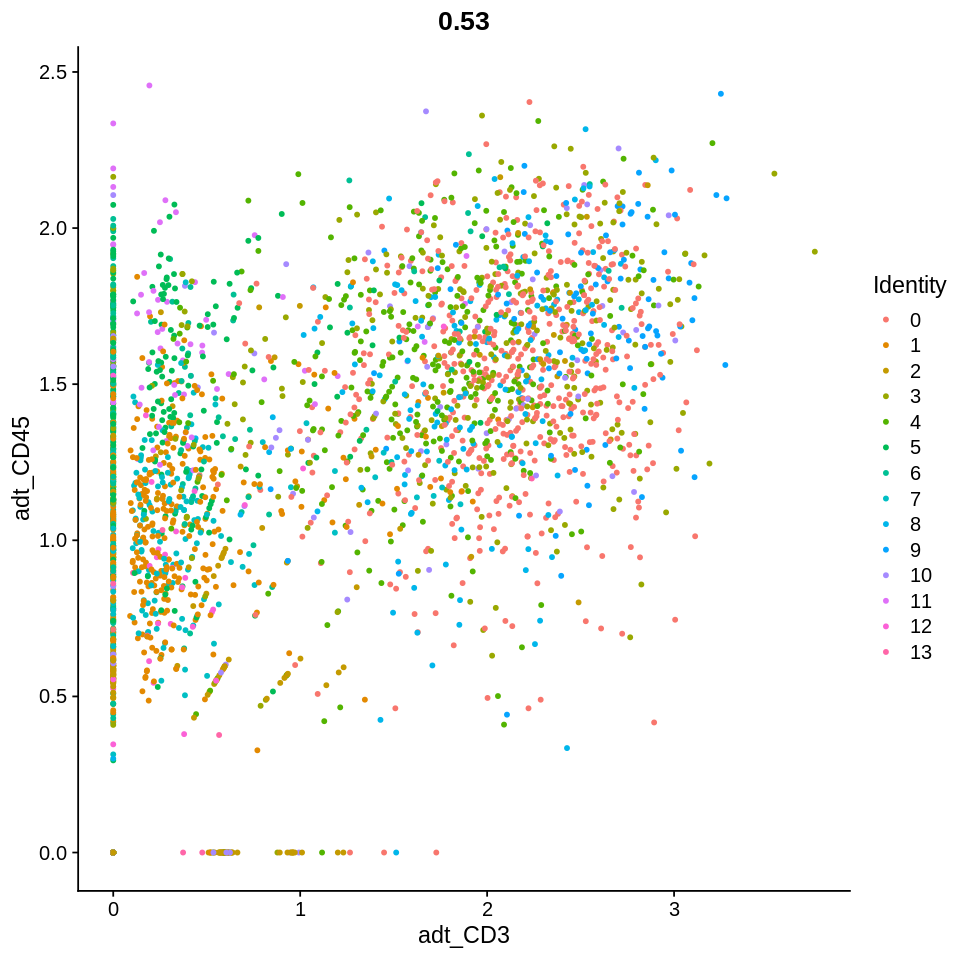

In [ ]:
FeatureScatter(yascp, feature1 = "adt_CD3", feature2 = "adt_CD45")

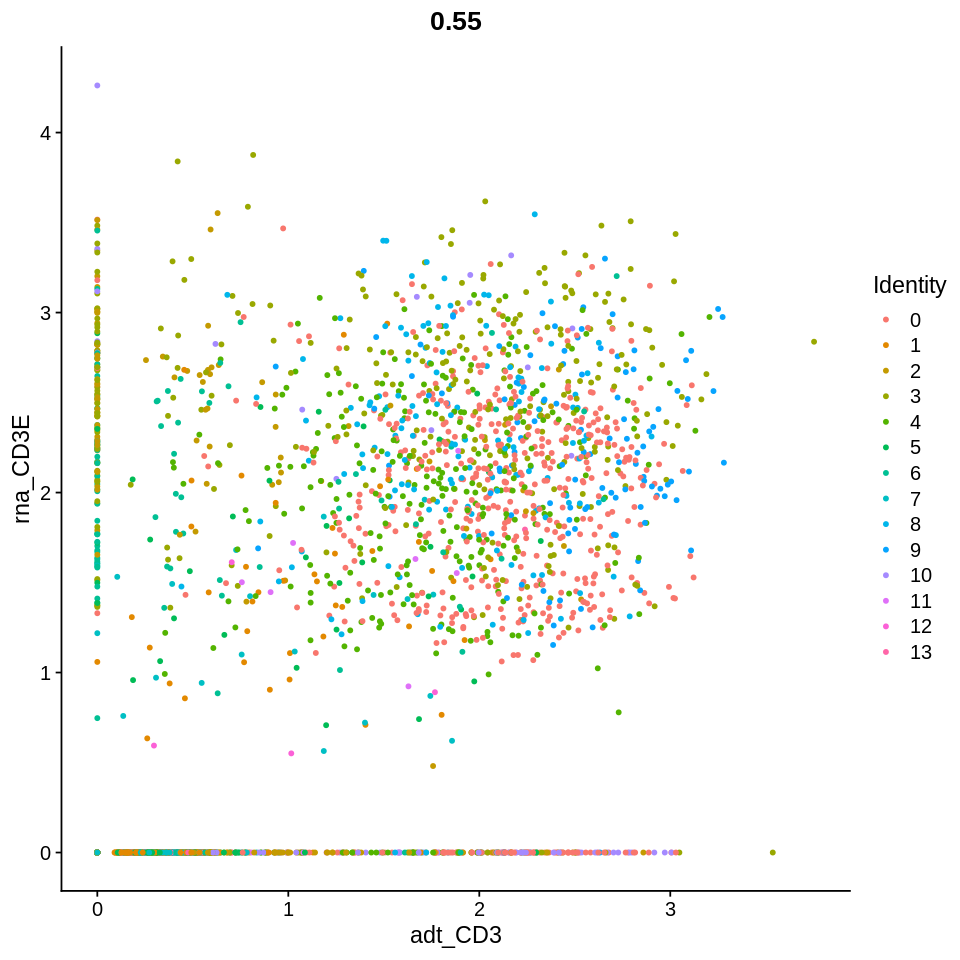

In [ ]:
# view relationship between protein and RNA
FeatureScatter(yascp, feature1 = "adt_CD3", feature2 = "rna_CD3E")

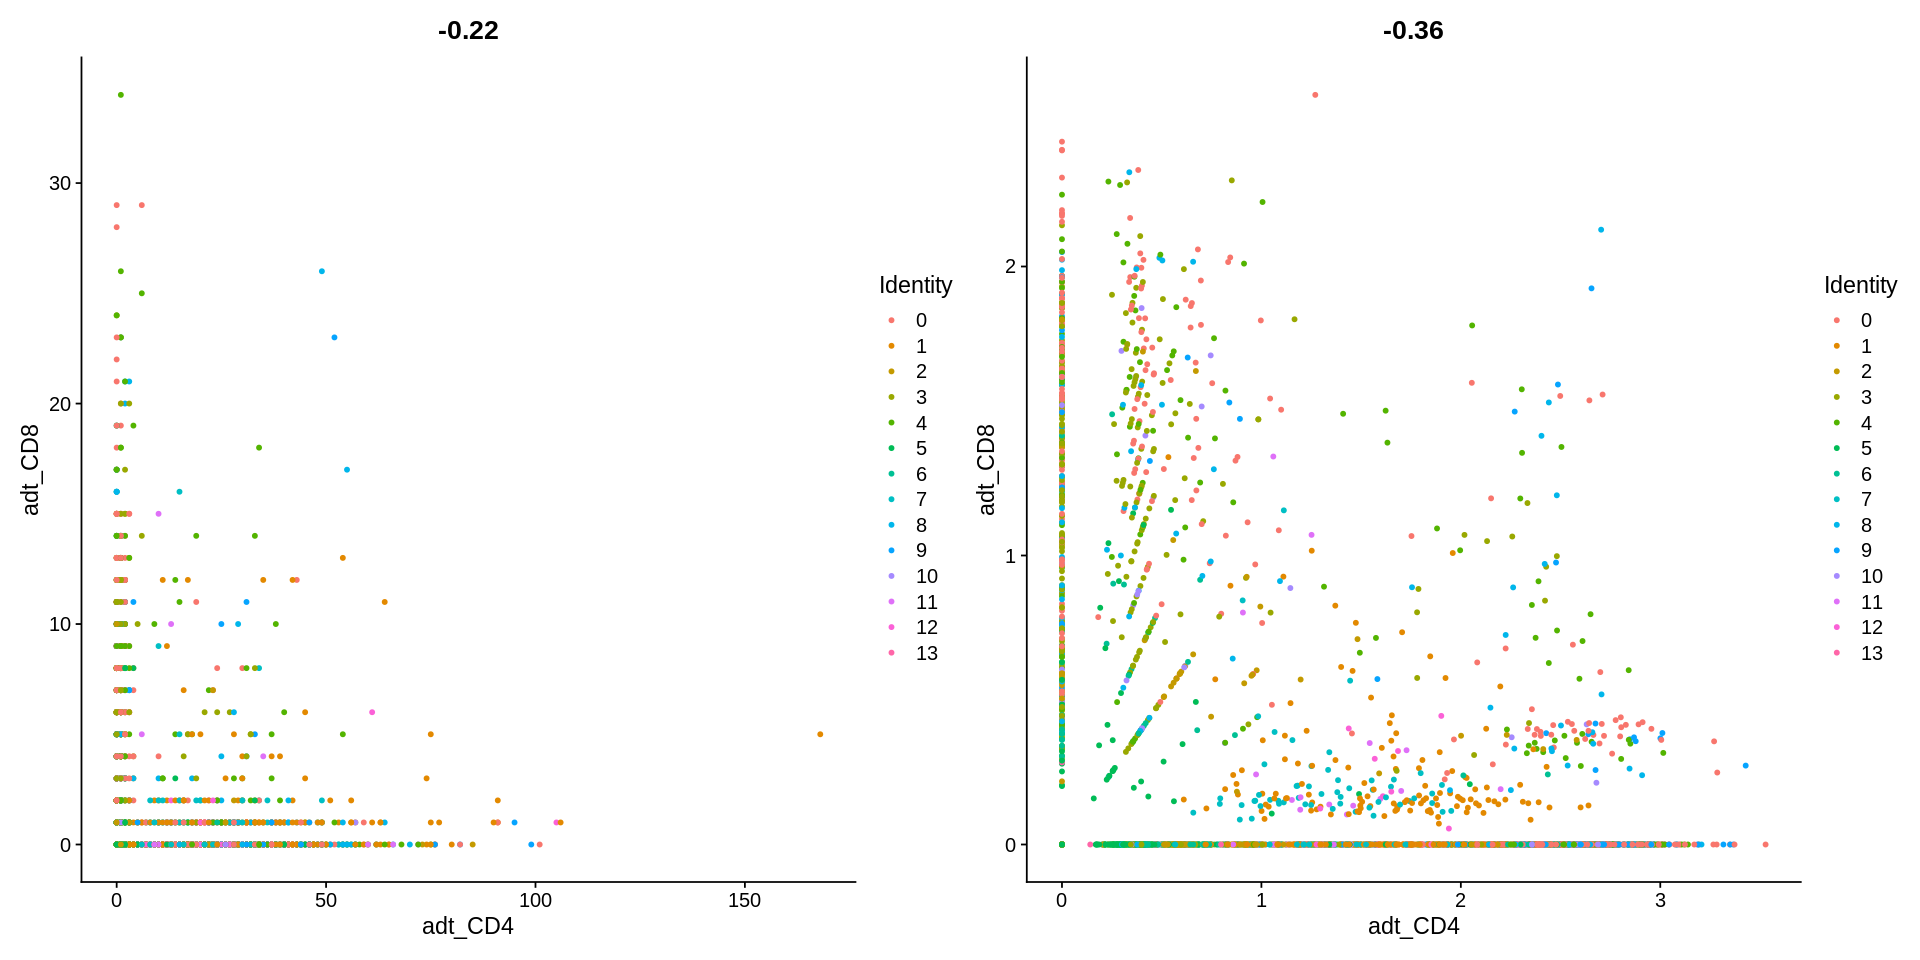

In [ ]:
# Let's look at the raw (non-normalized) ADT counts. You can see the values are quite high,
# particularly in comparison to RNA values. This is due to the significantly higher protein
# copy number in cells, which significantly reduces 'drop-out' in ADT data

# Set plot size
options(repr.plot.width = 16, repr.plot.height = 8)

p1sca <- FeatureScatter(yascp, feature1 = "adt_CD4", feature2 = "adt_CD8", slot = "counts")
p2sca <- FeatureScatter(yascp, feature1 = "adt_CD4", feature2 = "adt_CD8")
p1sca | p2sca

### 8.3.3 Ridge Plot of Protein Expression

The Ridge Plot displays the distribution of protein expression levels for **CD14** and **CD16** across different clusters. This type of plot is useful for comparing marker expression across cell populations, helping to identify specific subtypes of cells, such as monocytes (CD14 and CD16), and understand their heterogeneity in the dataset.

Picking joint bandwidth of 0.0389

Picking joint bandwidth of 0.122



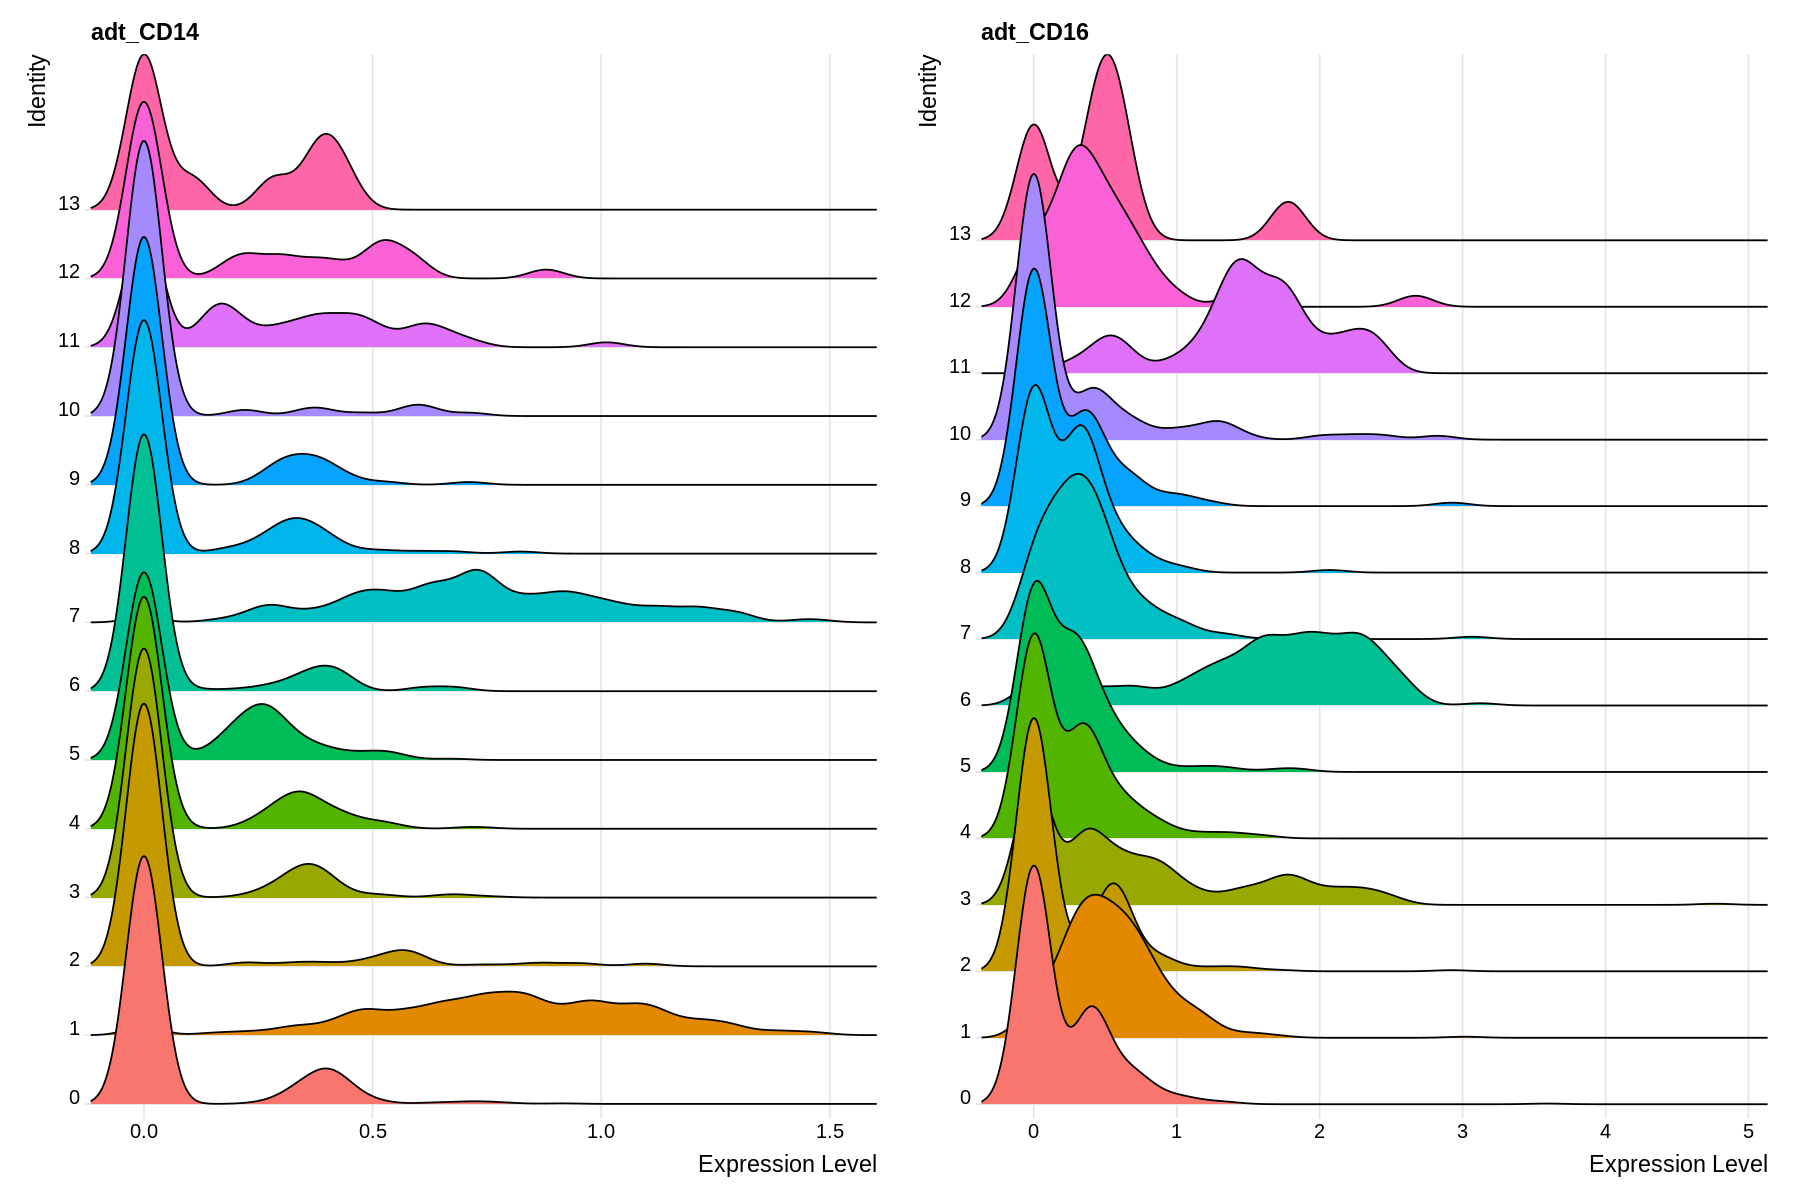

In [ ]:
# Set plot size
options(repr.plot.width = 15, repr.plot.height = 10)

# Ridge plots - from ggridges. Visualize single cell expression distributions in each cluster
#features = c("adt_CD14", "adt_CD16", "adt_CD19", "adt_CD11c", "adt_CD21", "adt_CD20")
features = c("adt_CD14", "adt_CD16")
RidgePlot(yascp, features = features, ncol = 2)

### 8.3.4 Dot Plot of Protein Expression

The Dot Plot displays the expression levels across various cell clusters. The size of each dot represents the percentage of cells in the cluster expressing a specific marker, while the color intensity indicates the average expression level. It is important to note that the expression values are scaled within the data shown in the plot, so the highest expression in a Dot Plot does not necessarily reflect objectively high expression. This visualization helps identify clusters with higher or lower marker expression, offering insights into cell-type distribution and marker variability

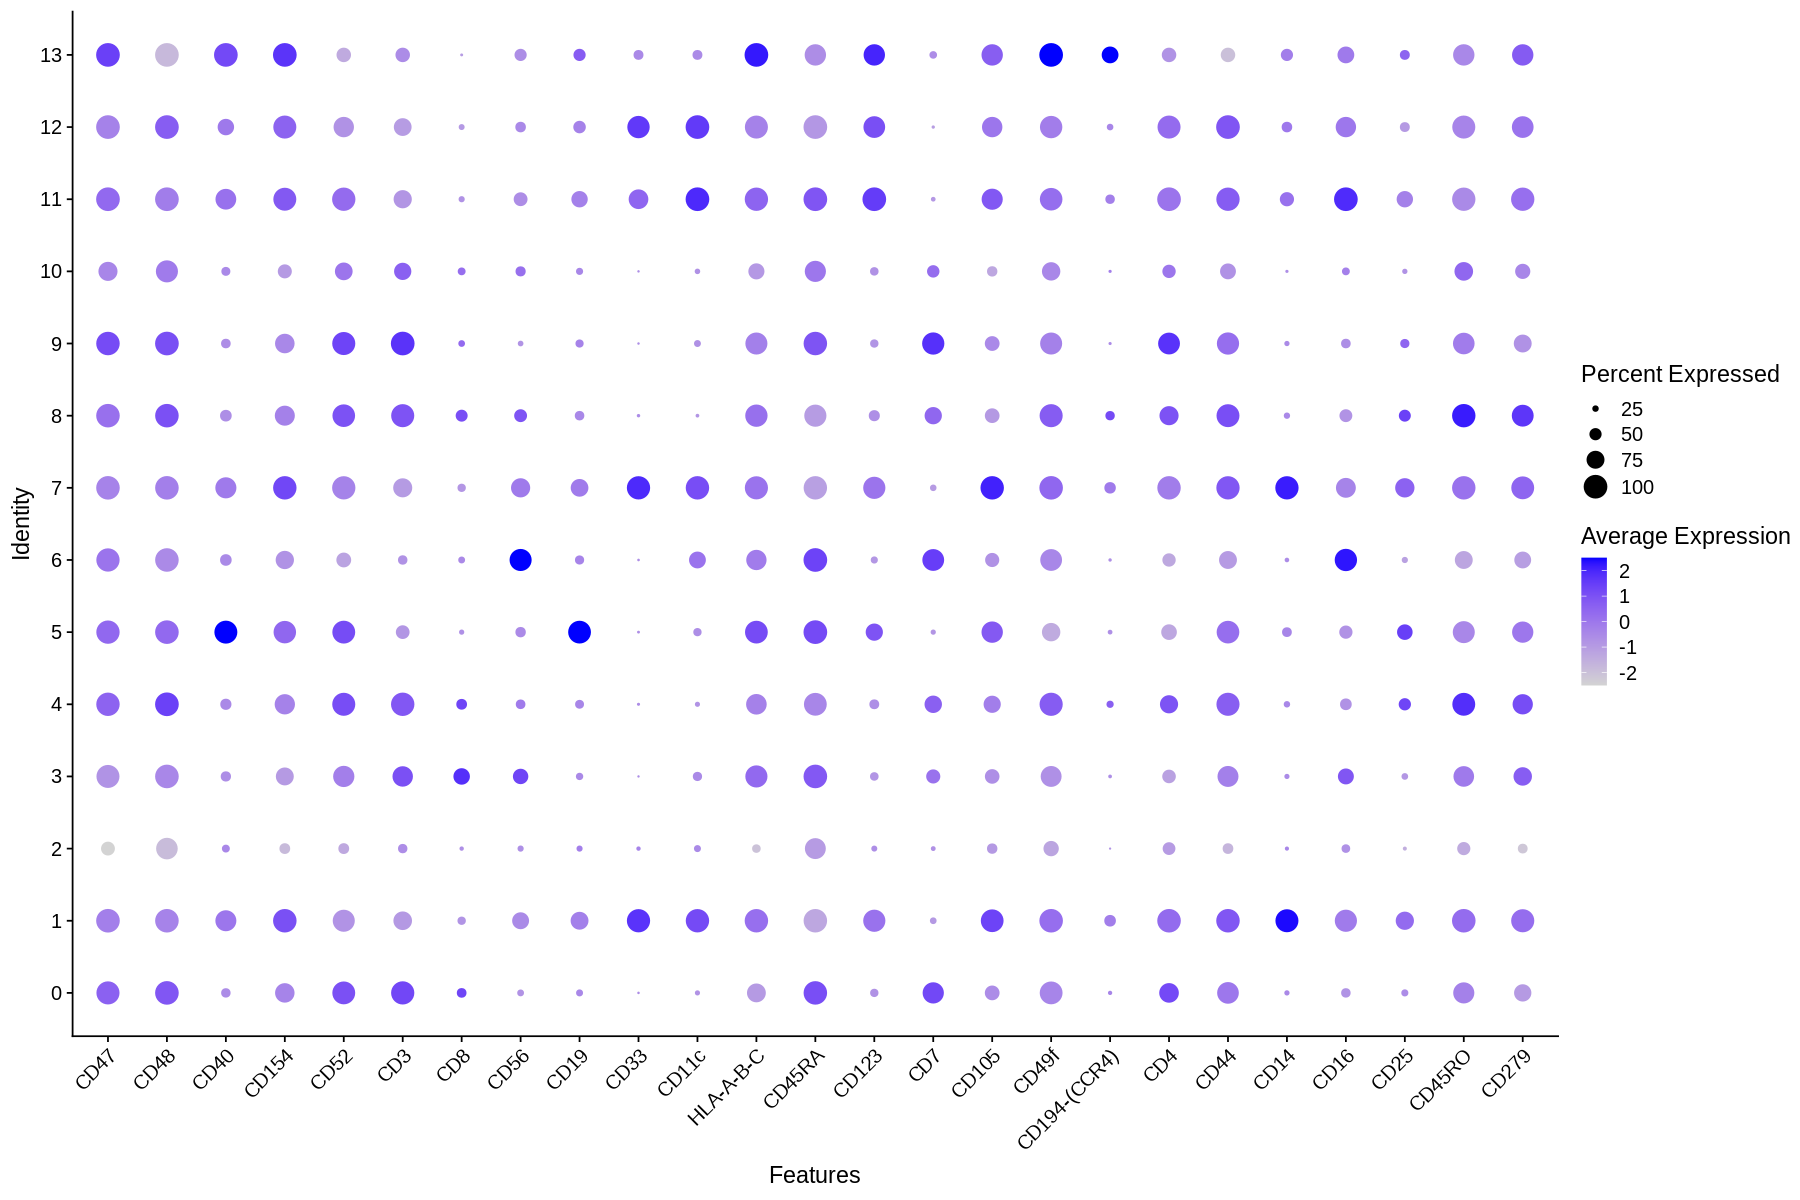

In [ ]:
# Dot plots - the size of the dot corresponds to the percentage of cells expressing the
# feature in each cluster. The color represents the average expression level
DefaultAssay(yascp) <- "ADT"
features = c('CD47','CD48','CD40','CD154','CD52','CD3','CD8','CD56','CD19','CD33','CD11c','HLA-A-B-C',
             'CD45RA','CD123','CD7','CD105','CD49f','CD194-(CCR4)','CD4','CD44','CD14','CD16','CD25','CD45RO','CD279')
DotPlot(yascp, features = features) + RotatedAxis()